# Анализ лояльности пользователей Яндекс Афиши

## Введение

Команда маркетинга хочет лучше понимать поведение пользователей платформы. Для этого в рамках проекта проводится исследовательский анализ данных, направленный на выявление пользователей, которые с большей вероятностью возвращаются на платформу и совершают повторные заказы. Понимание этих закономерностей необходимо для повышения эффективности маркетинговых решений и более рационального использования ресурсов.

В ходе работы анализируются данные о действиях пользователей и их заказах, чтобы определить ключевые поведенческие различия между разовыми и возвращающимися клиентами. Полученные выводы служат основой для дальнейших аналитических и прикладных шагов.

## Цели проекта

Ключевая цель проекта — определить, какие пользователи с наибольшей вероятностью возвращаются на платформу и делают повторные заказы, а также какие признаки и модели поведения этому способствуют.

Результаты проекта должны позволить:
- быстро выявлять перспективных клиентов и предлагать им персонализированные условия;
- точно настраивать рекламу на аудитории с высокой вероятностью возврата;
- оптимизировать маркетинговые бюджеты;
- повысить общий уровень удержания клиентов.



## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install psycopg2-binary

In [2]:
!pip install phik

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from phik import phik_matrix

In [4]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string)

In [6]:
query = '''
SELECT
      user_id,
      device_type_canonical,
      order_id,
      created_dt_msk AS order_dt,
      created_ts_msk AS order_ts,
      currency_code,
      revenue,
      tickets_count,
      created_dt_msk::date - LAG(created_dt_msk::date) OVER (PARTITION BY user_id ORDER BY created_dt_msk) AS days_since_prev,
      event_id,
      event_name_code AS event_name,
      event_type_main,
      service_name,
      region_name,
      city_name
FROM afisha.purchases AS p
JOIN afisha.events AS e USING(event_id)
LEFT JOIN afisha.city AS c USING(city_id)
LEFT JOIN afisha.regions AS r USING(region_id)
WHERE (device_type_canonical='desktop' or device_type_canonical='mobile') AND event_type_main <> 'фильм' 
ORDER BY user_id
'''

In [7]:
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [8]:
display(df.info())

display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

None

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


**Промежуточный вывод:**

- Всего 290 611 записей и 15 столбцов, данные выгружены корректно.  
- Есть пропуски в `days_since_prev` для первых заказов пользователей — логично.  
- Столбцы с категориями (`device_type_canonical`, `event_type_main`, `city_name`) можно привести к типу `category` для более эффективной работы с памятью и аналитикой.  
- Даты (`order_dt`, `order_ts`) корректны, `revenue` и `tickets_count` — числовые.  
- Планируется привести объекты к типам данных, удобным для анализа и агрегирования, а числовые столбцы — оптимизировать по разрядности для экономии памяти и повышения производительности вычислений.


---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [9]:
# создаем копию датасета до преобразований для возможности проверить сделанные изменения после предобработки
temp = df.copy() 
len(temp)

290611

In [10]:
df_kzt_rub = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [11]:
# Познакомимся с данными
display(df_kzt_rub.info())

display(df_kzt_rub.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [12]:
display(df_kzt_rub.isna().sum())

data       0
nominal    0
curs       0
cdx        0
dtype: int64

<div class="alert alert-info">
Проведена проверка данных с курсами валют: пропусков не обнаружено, все столбцы (`data`, `nominal`, `curs`, `cdx`) заполнены полностью.  
Видно, что столбец `data` имеет строковый тип, поэтому для корректного объединения с основным датасетом по дате заказа требуется приведение его к типу `datetime`.
</div>

In [13]:
# Преобразуем даты курса в datetime, объединяем с основным датасетом по дате заказа,
# создадим новый столбец revenue_rub, пересчитаем выручку в рубли для тенге,
# округляим до 2 знаков и удалим временные колонки

df_kzt_rub['data'] = pd.to_datetime(df_kzt_rub['data'])
df = df.merge(df_kzt_rub[['data', 'curs']], left_on = 'order_dt', right_on = 'data', how='left')

df['revenue_rub'] = df['revenue']

mask = df['currency_code'] == 'kzt'
df.loc[mask, 'revenue_rub'] = (df.loc[mask, 'revenue'] * df.loc[mask, 'curs'] / 100)

df['revenue_rub'] = df['revenue_rub'].round(2)

df.drop(['data', 'curs'], axis=1, inplace=True)

In [14]:
display(df.head())

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


<div class="alert alert-info">
Задача по приведению выручки к единой валюте выполнена. Все расчёты прошли корректно, полученные показатели выручки можно использовать для дальнейшего анализа.
</div>

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [15]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

None

Видим, что в  датасете единственный столбец с пустыми значениями — `days_since_prev`.

<div class="alert alert-info">
    Проверим наличие полных дубликатов.
</div>

In [16]:
display(df.duplicated().sum())

0

<div class="alert alert-info">
В датафрейме нет полных дубликатов строк. Далее проверим неполные дубликаты.
</div>

In [17]:
subset = ['user_id', 'order_ts', 'revenue_rub', 'tickets_count', 'service_name']
subset_duplicates_count = df.duplicated(subset=subset).sum()

display(subset_duplicates_count)

46

<div class="alert alert-info">
Визуально осмотрим эти возможные неявные дубликаты.
</div>

In [18]:
display(df[df.duplicated(subset=subset, keep=False)].sort_values(subset).head(10))

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
11758,06eb7897f65b433,mobile,1123983,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,69796237-909b-42a7-bfb5-c1b8574c4c76,театр,Билеты в руки,Светополянский округ,Глиноград,69.82
11759,06eb7897f65b433,mobile,1123867,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,69796237-909b-42a7-bfb5-c1b8574c4c76,театр,Билеты в руки,Светополянский округ,Глиноград,69.82
12677,08199117318954f,desktop,5592970,2024-07-31,2024-07-31 11:52:06,rub,0.00,3,0.0,553623,8aa79719-8122-4b50-ae2a-fa484d034c5c,другое,Билеты без проблем,Каменевский регион,Глиногорск,0.00
12678,08199117318954f,mobile,5593202,2024-07-31,2024-07-31 11:52:06,rub,0.00,3,0.0,553623,8aa79719-8122-4b50-ae2a-fa484d034c5c,другое,Билеты без проблем,Каменевский регион,Глиногорск,0.00
26868,0dc525d7bacbb0d,desktop,1930763,2024-07-31,2024-07-31 13:26:11,rub,1556.05,3,11.0,393430,b33d7a0b-a715-47e3-803e-02482884a73e,концерты,Лови билет!,Каменевский регион,Глиногорск,1556.05
26869,0dc525d7bacbb0d,desktop,1930705,2024-07-31,2024-07-31 13:26:11,rub,1556.05,3,0.0,393430,b33d7a0b-a715-47e3-803e-02482884a73e,концерты,Лови билет!,Каменевский регион,Глиногорск,1556.05
51539,1f49b8de206b285,mobile,2968673,2024-10-01,2024-10-01 11:32:40,rub,155.99,4,0.0,574431,d4344522-b7cf-4539-96c8-efece75e9b16,спорт,Билеты в руки,Медовская область,Радужсвет,155.99
51588,1f49b8de206b285,desktop,5378312,2024-10-01,2024-10-01 11:32:40,rub,155.99,4,0.0,574431,d4344522-b7cf-4539-96c8-efece75e9b16,спорт,Билеты в руки,Медовская область,Радужсвет,155.99
53681,206ea45ec11d478,mobile,1935113,2024-10-29,2024-10-29 16:46:54,rub,601.69,2,0.0,442183,dcf6f06f-8499-41d7-8bc2-a0e3d7afe313,концерты,Билеты в руки,Каменевский регион,Глиногорск,601.69
53682,206ea45ec11d478,mobile,1935171,2024-10-29,2024-10-29 16:46:54,rub,601.69,2,0.0,442183,dcf6f06f-8499-41d7-8bc2-a0e3d7afe313,концерты,Билеты в руки,Каменевский регион,Глиногорск,601.69


<div class="alert alert-info">
Удалим, оставив первые значения.
</div>

In [19]:
df = df.drop_duplicates(subset=subset, keep='first')

display(df.duplicated(subset=subset).sum())

0

<div class="alert alert-info">
В датафрейме обнаружены и удалены 46 неполных дубликатов строк.
</div>

In [20]:
# Для каждого столбца посмотрим уникальные значения и их количество. 
# Это поможет выбрать правильный тип для хранения данных.
for column in df.columns:
    print(f'\nСтолбец: {column}')
    display(df[column].sort_values().unique())
    display(df[column].sort_values().nunique())


Столбец: user_id


array(['0002849b70a3ce2', '0005ca5e93f2cf4', '000898990054619', ...,
       'fffcd3dde79eb2c', 'fffeeb3c120cf0b', 'ffff00725179321'],
      dtype=object)

21933


Столбец: device_type_canonical


array(['desktop', 'mobile'], dtype=object)

2


Столбец: order_id


array([      1,      30,      59, ..., 8653050, 8653079, 8653108])

290565


Столбец: order_dt


array(['2024-06-01T00:00:00.000000000', '2024-06-02T00:00:00.000000000',
       '2024-06-03T00:00:00.000000000', '2024-06-04T00:00:00.000000000',
       '2024-06-05T00:00:00.000000000', '2024-06-06T00:00:00.000000000',
       '2024-06-07T00:00:00.000000000', '2024-06-08T00:00:00.000000000',
       '2024-06-09T00:00:00.000000000', '2024-06-10T00:00:00.000000000',
       '2024-06-11T00:00:00.000000000', '2024-06-12T00:00:00.000000000',
       '2024-06-13T00:00:00.000000000', '2024-06-14T00:00:00.000000000',
       '2024-06-15T00:00:00.000000000', '2024-06-16T00:00:00.000000000',
       '2024-06-17T00:00:00.000000000', '2024-06-18T00:00:00.000000000',
       '2024-06-19T00:00:00.000000000', '2024-06-20T00:00:00.000000000',
       '2024-06-21T00:00:00.000000000', '2024-06-22T00:00:00.000000000',
       '2024-06-23T00:00:00.000000000', '2024-06-24T00:00:00.000000000',
       '2024-06-25T00:00:00.000000000', '2024-06-26T00:00:00.000000000',
       '2024-06-27T00:00:00.000000000', '2024-06-28

153


Столбец: order_ts


array(['2024-06-01T00:00:42.000000000', '2024-06-01T00:01:30.000000000',
       '2024-06-01T00:01:58.000000000', ...,
       '2024-10-31T23:59:24.000000000', '2024-10-31T23:59:51.000000000',
       '2024-10-31T23:59:54.000000000'], dtype='datetime64[ns]')

280753


Столбец: currency_code


array(['kzt', 'rub'], dtype=object)

2


Столбец: revenue


array([-9.076000e+01, -1.794000e+01, -1.077000e+01, ...,  4.870472e+04,
        6.493963e+04,  8.117454e+04])

42522


Столбец: tickets_count


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 19,
       27, 30, 37, 47, 57])

22


Столбец: days_since_prev


array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148.,  nan])

149


Столбец: event_id


array([  4436,   5785,   8817, ..., 591877, 592322, 592325])

22427


Столбец: event_name


array(['000a9c8d-65bb-4178-a5a8-9ddc1f3bf71e',
       '0015b11d-a3e0-4656-887a-383450a9b313',
       '00298e1a-ae90-482b-819d-ba88ceff59b0', ...,
       'fff20f2b-de72-451a-8168-b765352e502c',
       'fff68929-41eb-4dd7-90bf-76d3ae8b652f',
       'fffd87ef-5469-4684-af21-4f9b86a13189'], dtype=object)

15248


Столбец: event_type_main


array(['выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр',
       'ёлки'], dtype=object)

7


Столбец: service_name


array(['Crazy ticket!', 'Show_ticket', 'Билет по телефону',
       'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки',
       'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка',
       'Вперёд!', 'Выступления.ру', 'Городской дом культуры',
       'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ',
       'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!',
       'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная',
       'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет',
       'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко'],
      dtype=object)

36


Столбец: region_name


array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

81


Столбец: city_name


array(['Айкольск', 'Айсуак', 'Акбастау', 'Акбасты', 'Акжолтау',
       'Алтынкала', 'Алтынсай', 'Байкуль', 'Байсары', 'Байтерековск',
       'Беловодск', 'Белоярск', 'Бережанка', 'Бережанск', 'Березиногорск',
       'Березиноск', 'Березовцево', 'Берестовец', 'Берестяград',
       'Берёзиново', 'Берёзовка', 'Берёзогорск', 'Берёзодальн',
       'Берёзополье', 'Берёзореч', 'Берёзоречье', 'Бозарык', 'Боровлянск',
       'Буркиттау', 'Бурьяново', 'Верховино', 'Верховка', 'Верхозолотск',
       'Верхозорье', 'Верхоозёров', 'Ветеринск', 'Вишнёво',
       'Вишнёвогорск', 'Вишнёводск', 'Водниково', 'Глиногорск',
       'Глиногорь', 'Глиноград', 'Глинозолото', 'Глинозорь', 'Глинолес',
       'Глинополин', 'Глинополье', 'Глинополянск', 'Глинореч', 'Глинянск',
       'Голубевск', 'Голубино', 'Гореловск', 'Горицветск', 'Горноград',
       'Горнодолинск', 'Горнолесье', 'Горнолуг', 'Горнополец',
       'Горнополье', 'Горнополянск', 'Горнополяровск', 'Горнополёк',
       'Горноставинск', 'Горяново', '

352


Столбец: revenue_rub


array([-9.076000e+01, -1.794000e+01, -1.077000e+01, ...,  4.870472e+04,
        6.493963e+04,  8.117454e+04])

43089

In [21]:
for column in ['currency_code', 'device_type_canonical', 'event_type_main']:
    df[column] = df[column].astype('category')
    
for column in ['user_id', 'event_name', 'service_name', 'region_name', 'city_name']:
    df[column] = df[column].astype('string')
    
for column in ['order_id', 'tickets_count']:
    df[column] = pd.to_numeric(df[column], downcast='integer')
    
for column in ['revenue', 'days_since_prev', 'revenue_rub']:
    df[column] = pd.to_numeric(df[column], downcast='float')
    
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290565 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290565 non-null  string        
 1   device_type_canonical  290565 non-null  category      
 2   order_id               290565 non-null  int32         
 3   order_dt               290565 non-null  datetime64[ns]
 4   order_ts               290565 non-null  datetime64[ns]
 5   currency_code          290565 non-null  category      
 6   revenue                290565 non-null  float32       
 7   tickets_count          290565 non-null  int8          
 8   days_since_prev        268632 non-null  float32       
 9   event_id               290565 non-null  int64         
 10  event_name             290565 non-null  string        
 11  event_type_main        290565 non-null  category      
 12  service_name           290565 non-null  stri

None

In [22]:
# Проверим, нужна ли нормализация данных
'''
for column in ['currency_code', 'device_type_canonical', 'event_type_main']:
    print(f'\nСтолбец: {column}')
    display(df[column].sort_values().unique())
    display(df[column].sort_values().nunique())
'''

"\nfor column in ['currency_code', 'device_type_canonical', 'event_type_main']:\n    print(f'\nСтолбец: {column}')\n    display(df[column].sort_values().unique())\n    display(df[column].sort_values().nunique())\n"

In [23]:
# Анализ категориальных значений
for column in ['currency_code', 'device_type_canonical', 'event_type_main']:
    print(f"\nColumn: {column}")
    print("Unique values:", df[column].unique())
    print("Missing values count:", df[column].isna().sum())
    print("Value counts:")
    print(df[column].value_counts(dropna=False), "\n")    


Column: currency_code
Unique values: ['rub', 'kzt']
Categories (2, object): ['rub', 'kzt']
Missing values count: 0
Value counts:
rub    285497
kzt      5068
Name: currency_code, dtype: int64 


Column: device_type_canonical
Unique values: ['mobile', 'desktop']
Categories (2, object): ['mobile', 'desktop']
Missing values count: 0
Value counts:
mobile     232459
desktop     58106
Name: device_type_canonical, dtype: int64 


Column: event_type_main
Unique values: ['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт', 'ёлки']
Categories (7, object): ['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт', 'ёлки']
Missing values count: 0
Value counts:
концерты    115265
театр        67311
другое       65850
спорт        21904
стендап      13393
выставки      4853
ёлки          1989
Name: event_type_main, dtype: int64 



Нормализация данных не требуется, все категории корректны и явных признаков отсутствующей информации нет.
Далее проверим распределение числовых данных в `tickets_count` .

In [24]:
vc_abs = df['tickets_count'].value_counts()
vc_rel = df['tickets_count'].value_counts(normalize=True).round(4)

df_vc = pd.DataFrame({
        'absolute': vc_abs,
        'relative': vc_rel
})

print('Распределение количества заказов по количеству билетов:', '\n', df_vc)

Распределение количества заказов по количеству билетов: 
     absolute  relative
3      92232    0.3174
2      83798    0.2884
4      54803    0.1886
1      41788    0.1438
5      13474    0.0464
6       4282    0.0147
7         62    0.0002
9         38    0.0001
8         21    0.0001
10        19    0.0001
11        13    0.0000
13         7    0.0000
17         6    0.0000
19         5    0.0000
12         4    0.0000
14         4    0.0000
15         2    0.0000
27         2    0.0000
30         2    0.0000
37         1    0.0000
47         1    0.0000
57         1    0.0000


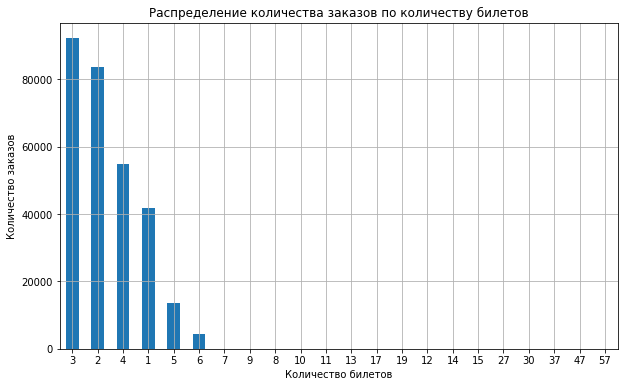

In [25]:
vc_abs.plot(figsize=(10, 6),
            kind='bar',
            legend=False,
            grid=True,
            rot=0,
            title='Распределение количества заказов по количеству билетов',
            xlabel='Количество билетов',
            ylabel='Количество заказов'
)

plt.show()

Большинство заказов содержат 1–5 билетов, при этом наибольшее число заказов приходится на 3 билета (92 247) и 2 билета (83 807). А заказы с большим количеством билетов встречаются крайне. Их оставим, т.к. такие ситуации могут иногда встречаться и было бы некорректно относить их к выбросам.


Далее проверим распределение числовых данных в `revenue_rub` и при необходимости отфильтруем выбросы по 99-му перцентилю.

In [26]:
df['revenue_rub'].describe()

count    290565.000000
mean        555.596191
std         875.534851
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

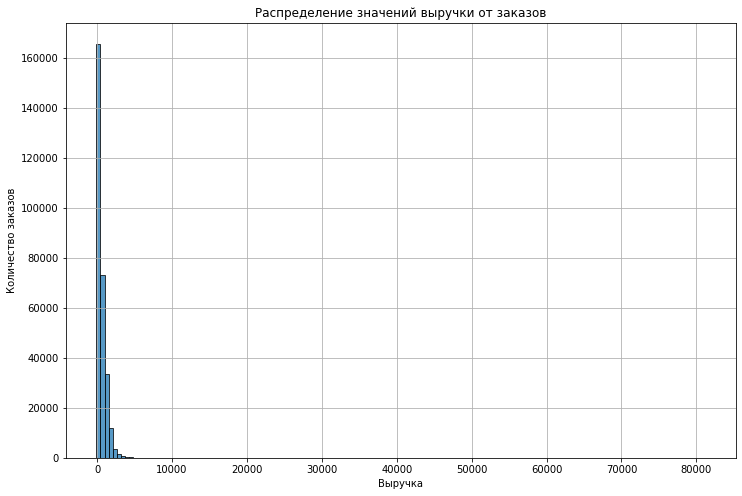

In [27]:
df['revenue_rub'].plot(kind='hist',
                       figsize=(12, 8),
                       bins=150,
                       alpha=0.75,
                       edgecolor='black',
                       rot=0
)

plt.title('Распределение значений выручки от заказов')
plt.xlabel('Выручка')
plt.ylabel('Количество заказов')

plt.grid()

plt.show()

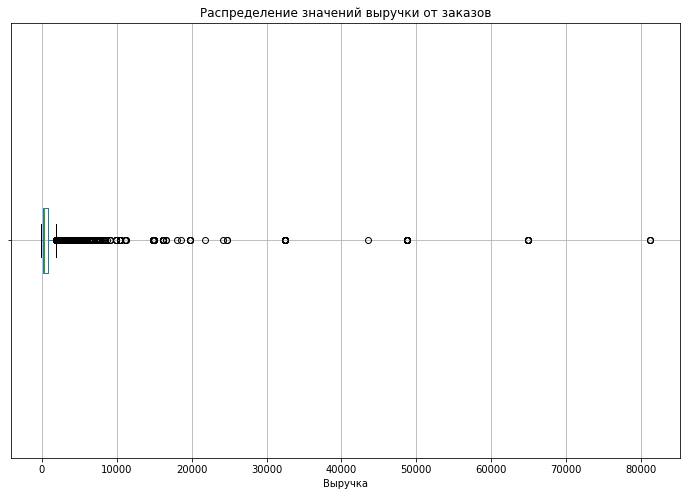

In [28]:
df['revenue_rub'].plot(kind='box',
                       figsize=(12, 8),
                       vert=False,
                       grid=True,
                       label=''
)

plt.title('Распределение значений выручки от заказов')
plt.xlabel('Выручка')

plt.show()

In [29]:
# Количество отрицательных и нулевых значений
neg_count = (df['revenue_rub'] < 0).sum()
zero_count = (df['revenue_rub'] == 0).sum()

print('Количество отрицательных значений:', neg_count, '\nКоличество нулевых значений:', zero_count)

Количество отрицательных значений: 381 
Количество нулевых значений: 5522


В датасете обнаружено 381 отрицательное значение и 5 522 нулевых. Отрицательные значения удаляем, так как они некорректны, а нулевые оставляем, так как их много, а также они могут иметь смысл для дальнейшей работы.

In [30]:
df_clean = df[df['revenue_rub'] >= 0]

In [31]:
# Проведём фильтрацию выбросов по 99-му перцентилю в revenue_rub
outliers = df_clean['revenue_rub'].quantile(0.99)
df_clean = df_clean.loc[df_clean['revenue_rub'] < outliers]

display(df_clean['revenue_rub'].describe())

count    287177.000000
mean        517.400818
std         509.336945
min           0.000000
25%         112.440002
50%         344.299988
75%         788.640015
max        2627.000000
Name: revenue_rub, dtype: float64

```python
# Предыдущий код
df_clean['revenue_rub'].plot(kind='hist',
                             figsize=(12, 8),
                             bins=150,
                             alpha=0.75,
                             edgecolor='black',
                             rot=0
)

plt.title('Распределение значений выручки от заказов')
plt.xlabel('Выручка')
plt.ylabel('Количество заказов')

plt.grid()

plt.show()
```

```python
# Предыдущий код
df_clean['revenue_rub'].plot(kind='box',
                             figsize=(12, 8),
                             vert=False,
                             grid=True,
                             label=''
)

plt.title('Распределение значений выручки от заказов')
plt.xlabel('Выручка')

plt.show()
```

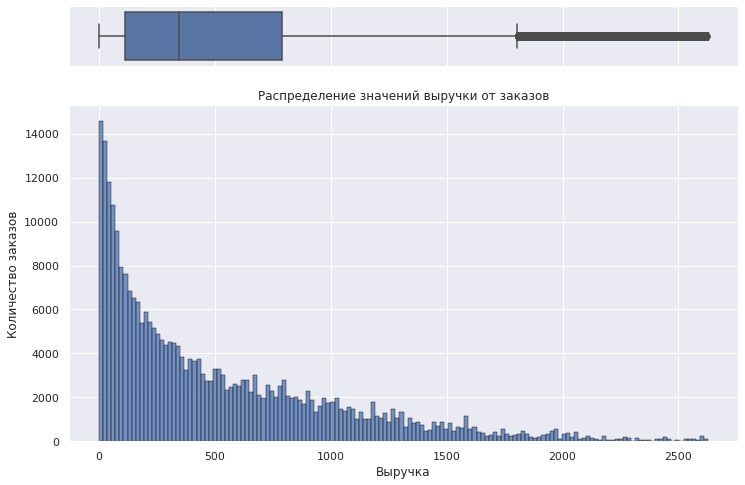

In [32]:
# Настройка темы seaborn
sns.set_theme(style="darkgrid")
 
# Создание фигуры с двумя осями: boxplot сверху, histogram снизу
f, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Boxplot
sns.boxplot(x=df_clean['revenue_rub'], orient="h", ax=ax_box)
ax_box.set(xlabel='')

# Histogram 
sns.histplot(df_clean['revenue_rub'], bins=150, alpha=0.75, edgecolor='black', ax=ax_hist)
ax_hist.set(title='Распределение значений выручки от заказов',
            xlabel='Выручка',
            ylabel='Количество заказов')
ax_hist.grid(True)

plt.show()

In [33]:
# Проверим сколько удалено строк датасета
a, b = len(temp), len(df_clean)
print('Было строк в исходном датасете:', a,
      '\nОсталось строк в датасете после обработки:', b,
      '\nУдалено строк в датасете после обработки:', a-b,
      '\nПроцент потерь:', round((a-b)/a*100, 2), '%')

Было строк в исходном датасете: 290611 
Осталось строк в датасете после обработки: 287177 
Удалено строк в датасете после обработки: 3434 
Процент потерь: 1.18 %


**Выводы по предобработке данных:**

- Пересчёт выручки из KZT в RUB выполнялся по дневному курсу, сопоставленному с датой заказа, с использованием датасета `final_tickets_tenge_df.csv`.
- Даты (`order_dt`, `order_ts`) имеют тип `datetime64[ns]` — корректно, можно использовать для анализа временных интервалов. 
- Категориальные столбцы (`device_type_canonical`, `currency_code`, `event_type_main`) приведены к типу данных `category`, что экономит память.
- Числовые столбцы `revenue`, `days_since_prev` и `revenue_rub` приведены к `float32`, `tickets_count` к `int8`, `order_id` к `int32` — размерность оптимизирована, что уменьшает потребление памяти.
- Остальные строки (`user_id`, `event_name`, `service_name`, `region_name`, `city_name`) приведены к строковому типу данных.
- Выручка приведена к единой валюте (рубли) и сохранена в новый столбец `revenue_rub`.  
- В столбце `days_since_prev` есть пропуски — логично для первых заказов пользователей.  
- Категориальные данные не требовали нормализации.
- Распределение количества билетов (`tickets_count`) показало, что большинство заказов содержат 1–5 билетов, редкие заказы с большим количеством оставлены без изменений.  
- Для выручки (`revenue_rub`) выявлены отрицательные значения (381) и нулевые (5 522); отрицательные значения удалены, нулевые оставлены.  
- Фильтрация выбросов по 99-му перцентилю в `revenue_rub` выполнена после удаления отрицательных значений выручки.
- Из исходного датасета с 290 611 строк осталось 287 177, было удалено 3 434 строк, что составляет примерно 1,18 % от общего объема данных.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [34]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287177 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287177 non-null  string        
 1   device_type_canonical  287177 non-null  category      
 2   order_id               287177 non-null  int32         
 3   order_dt               287177 non-null  datetime64[ns]
 4   order_ts               287177 non-null  datetime64[ns]
 5   currency_code          287177 non-null  category      
 6   revenue                287177 non-null  float32       
 7   tickets_count          287177 non-null  int8          
 8   days_since_prev        265491 non-null  float32       
 9   event_id               287177 non-null  int64         
 10  event_name             287177 non-null  string        
 11  event_type_main        287177 non-null  category      
 12  service_name           287177 non-null  stri

In [35]:
df_sorted = df_clean.sort_values(by=['user_id', 'order_dt'])

df_user_profile = df_sorted.groupby('user_id').agg(
    first_order_dt=('order_dt', 'first'),
    last_order_dt=('order_dt', 'last'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue=('revenue', 'mean'),
    avg_tickets_count=('tickets_count', 'mean'),
    avg_days_between_orders=('days_since_prev', 'mean')
)

In [36]:
# Добавим 2 столбца с бинарными признаками
df_user_profile['is_two'] = (df_user_profile['total_orders'] >= 2).astype(int)
df_user_profile['is_five'] = (df_user_profile['total_orders'] >= 5).astype(int)

In [37]:
df_user_profile.info()

display(df_user_profile.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 21832 entries, 0002849b70a3ce2 to ffff00725179321
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_dt           21832 non-null  datetime64[ns]
 1   last_order_dt            21832 non-null  datetime64[ns]
 2   first_device             21832 non-null  object        
 3   first_region             21832 non-null  string        
 4   first_service            21832 non-null  string        
 5   first_event_type         21832 non-null  object        
 6   total_orders             21832 non-null  int64         
 7   avg_revenue              21832 non-null  float32       
 8   avg_tickets_count        21832 non-null  float64       
 9   avg_days_between_orders  13501 non-null  float32       
 10  is_two                   21832 non-null  int64         
 11  is_five                  21832 non-null  int64         
dtypes: datetime64

,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.000000,NaN,0,0
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010010,3.000000,75.000000,1,0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213318,2.666667,51.000000,1,0
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.000000,NaN,0,0
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.309998,1.500000,16.000000,1,0
000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,Лови билет!,концерты,13,1175.808472,3.307692,0.083333,1,1
00147c9209d45d3,2024-06-25,2024-06-25,mobile,Каменевский регион,Облачко,концерты,2,352.945007,1.500000,0.000000,1,0
0018ecd8a38a51b,2024-07-25,2024-07-25,mobile,Медовская область,Билеты без проблем,спорт,1,0.000000,3.000000,NaN,0,0
00199a573901564,2024-06-17,2024-06-17,mobile,Каменевский регион,Билеты без проблем,концерты,1,588.119995,4.000000,NaN,0,0


Для каждого пользователя сформированы ключевые характеристики: даты первого и последнего заказа, устройство и регион первого заказа, билетный партнёр, жанр первого посещённого мероприятия, общее количество заказов, средняя выручка и среднее количество билетов в заказе, а также среднее время между заказами. Дополнительно введены бинарные признаки `is_two` (пользователь совершил 2 и более заказов) и `is_five` (5 и более заказов).

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [38]:
# создаем копию датасета до преобразований для возможности проверить сделанные изменения после обработки
temp_user_profile = df_user_profile.copy()
len(temp_user_profile)

21832

In [39]:
print(f'Общее число пользователей: {len(df_user_profile)}\n'
      f'Средняя выручка с одного заказа: {df_user_profile["avg_revenue"].mean():.2f}\n'
      f'Доля пользователей, совершивших 2 и более заказов: {df_user_profile["is_two"].mean():.2%}\n'
      f'Доля пользователей, совершивших 5 и более заказов: {df_user_profile["is_five"].mean():.2%}')

Общее число пользователей: 21832
Средняя выручка с одного заказа: 627.91
Доля пользователей, совершивших 2 и более заказов: 61.71%
Доля пользователей, совершивших 5 и более заказов: 28.98%


In [40]:
numeric_cols = ['total_orders', 'avg_tickets_count', 'avg_days_between_orders']

display(df_user_profile[numeric_cols].describe())

,total_orders,avg_tickets_count,avg_days_between_orders
count,21832.000000,21832.000000,13501.000000
mean,13.153948,2.743852,15.876880
std,121.509864,0.913377,22.345535
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.750000,8.000000
75%,5.000000,3.080000,20.500000
max,10162.000000,11.000000,148.000000


- В столбце `total_orders` выявлен явный выброс — пользователь с 10 162 заказами, что значительно превышает 99-й перцентиль и искажает среднее значение.  
- В столбцах `avg_tickets_count` и `avg_days_between_orders` присутствуют экстремальные значения, но они менее критичны.  
- Отфильтруем пользователей с экстремально большим числом заказов (выше 95-го или 99-го перцентиля) перед дальнейшим анализом.

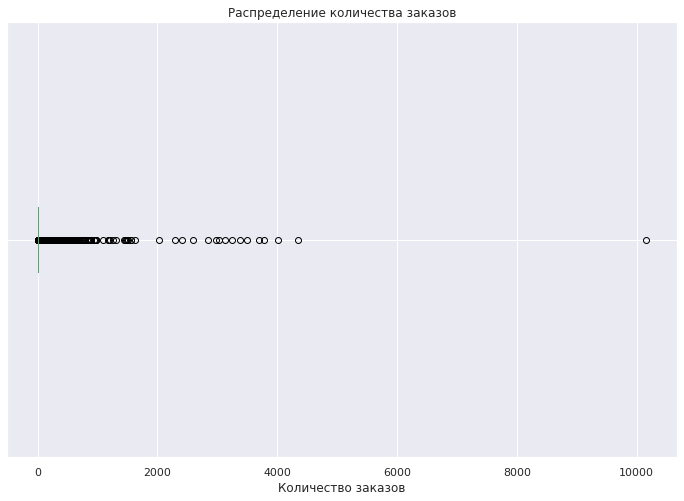

In [41]:
df_user_profile['total_orders'].plot(kind='box',
                                       figsize=(12, 8),
                                       vert=False,
                                       grid=True,
                                       label=''
)

plt.title('Распределение количества заказов')
plt.xlabel('Количество заказов')

plt.show()

In [42]:
# Изучим данные при фильтрации по 95 и 99 процентилям
q95 = df_user_profile['total_orders'].quantile(0.95)
q99 = df_user_profile['total_orders'].quantile(0.99)

df_99 = df_user_profile[df_user_profile['total_orders'] <= q99]
df_95 = df_user_profile[df_user_profile['total_orders'] <= q95]

desc_99 = df_99['total_orders'].describe()
desc_95 = df_95['total_orders'].describe()

describe_total_orders = pd.DataFrame({
    '99_percentile': desc_99,
    '95_percentile': desc_95
})

display(describe_total_orders)

,99_percentile,95_percentile
count,21616.000000,20741.000000
mean,6.492506,4.047635
std,14.293527,5.110868
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,5.000000,5.000000
max,152.000000,31.000000


Для дальнейших расчётов и EDA целесообразно использовать датафрейм `df_99` с фильтрацией по 99-му перцентилю `total_orders`: она убирает аномальные выбросы, не искажая поведение основной массы пользователей и сохраняя репрезентативность выборки.

In [43]:
df_99.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21616 entries, 0002849b70a3ce2 to ffff00725179321
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_dt           21616 non-null  datetime64[ns]
 1   last_order_dt            21616 non-null  datetime64[ns]
 2   first_device             21616 non-null  object        
 3   first_region             21616 non-null  string        
 4   first_service            21616 non-null  string        
 5   first_event_type         21616 non-null  object        
 6   total_orders             21616 non-null  int64         
 7   avg_revenue              21616 non-null  float32       
 8   avg_tickets_count        21616 non-null  float64       
 9   avg_days_between_orders  13285 non-null  float32       
 10  is_two                   21616 non-null  int64         
 11  is_five                  21616 non-null  int64         
dtypes: datetime64

In [44]:
# Проверим сколько удалено строк датасета
a, b = len(temp_user_profile), len(df_99)
print('Было строк в исходном датасете:', a,
      '\nОсталось строк в датасете после обработки:', b,
      '\nУдалено строк в датасете после обработки:', a-b,
      '\nПроцент потерь:', round((a-b)/a*100, 2), '%')

Было строк в исходном датасете: 21832 
Осталось строк в датасете после обработки: 21616 
Удалено строк в датасете после обработки: 216 
Процент потерь: 0.99 %


**Выводы по профилю пользователей:**  

Был сформирован полный профиль каждого пользователя с ключевыми характеристиками заказов и бинарными признаками активности (`is_two`, `is_five`). При этом выявлены экстремальные выбросы по общему количеству заказов, которые были удалены с помощью фильтрации по 99-му перцентилю. Эта фильтрация затронула менее 1 % пользователей и позволила устранить аномальные значения, не влияя на репрезентативность основной выборки.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [45]:
df_99.info()
display(df_99.head())

<class 'pandas.core.frame.DataFrame'>
Index: 21616 entries, 0002849b70a3ce2 to ffff00725179321
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_dt           21616 non-null  datetime64[ns]
 1   last_order_dt            21616 non-null  datetime64[ns]
 2   first_device             21616 non-null  object        
 3   first_region             21616 non-null  string        
 4   first_service            21616 non-null  string        
 5   first_event_type         21616 non-null  object        
 6   total_orders             21616 non-null  int64         
 7   avg_revenue              21616 non-null  float32       
 8   avg_tickets_count        21616 non-null  float64       
 9   avg_days_between_orders  13285 non-null  float32       
 10  is_two                   21616 non-null  int64         
 11  is_five                  21616 non-null  int64         
dtypes: datetime64

,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.000000,NaN,0,0
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010010,3.000000,75.0,1,0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213318,2.666667,51.0,1,0
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.000000,NaN,0,0
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


In [46]:
df_fet_abs = df_99['first_event_type'].value_counts()
df_fet_rel = df_99['first_event_type'].value_counts(normalize=True).round(4)

df_fet = pd.DataFrame({
    'absolute': df_fet_abs,
    'relative': df_fet_rel
})

title_fet = 'Количество пользователей по типу первого мероприятия'

print(title_fet, df_fet, sep='\n')

Количество пользователей по типу первого мероприятия
          absolute  relative
концерты      9556    0.4421
другое        5397    0.2497
театр         4251    0.1967
стендап       1118    0.0517
спорт          795    0.0368
выставки       406    0.0188
ёлки            93    0.0043


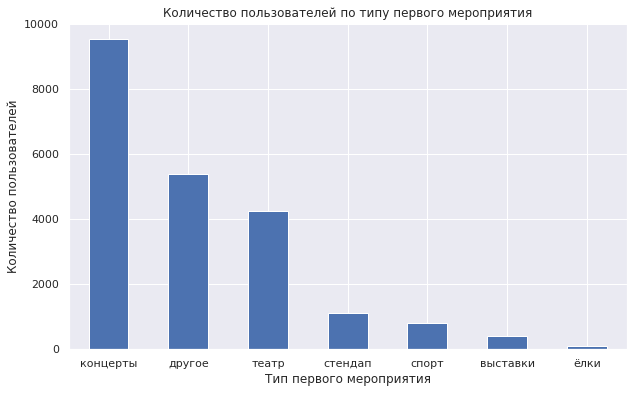

In [47]:
df_fet_abs.plot(figsize=(10, 6),
            kind='bar',
            legend=False,
            rot=0,
            grid=True,
            title=title_fet,
            xlabel='Тип первого мероприятия',
            ylabel='Количество пользователей'
)

plt.show()

Большая часть пользователей совершает первый заказ на **концерты** (44%) и **другое** (25%), что показывает явные «точки входа». Малые сегменты, такие как **ёлки** и **выставки**, составляют менее 2% пользователей и имеют ограниченную статистическую значимость.

In [48]:
df_fd_abs = df_99['first_device'].value_counts()
df_fd_rel = df_99['first_device'].value_counts(normalize=True).round(4)

df_fd = pd.DataFrame({
    'absolute': df_fd_abs,
    'relative': df_fd_rel
})

title_fd = 'Количество пользователей по типу устройства, с которого совершена первая покупка'

print(title_fd, df_fd, sep='\n')

Количество пользователей по типу устройства, с которого совершена первая покупка
         absolute  relative
mobile      17883    0.8273
desktop      3733    0.1727


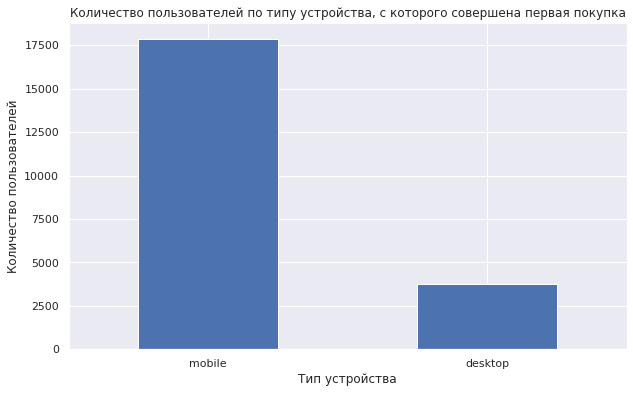

In [49]:
df_fd_abs.plot(figsize=(10, 6),
            kind='bar',
            legend=False,
            rot=0,
            grid=True,
            title=title_fd,
            xlabel='Тип устройства',
            ylabel='Количество пользователей'
)

plt.show()

Большинство пользователей (82,7%) совершают первый заказ с **мобильных устройств**, что делает мобильную платформу основным каналом входа. **Десктоп** используется меньшей частью пользователей (17,3%), составляя второстепенный сегмент.


In [50]:
df_fr_abs = df_99['first_region'].value_counts()
df_fr_rel = df_99['first_region'].value_counts(normalize=True).astype(float).round(4)

df_fr = pd.DataFrame({
    'absolute': df_fr_abs,
    'relative': df_fr_rel
})

title_fr = 'Топ-10 регионов проведения мероприятия из первого заказа по количеству пользователей'

print('Регионы проведения мероприятия из первого заказа по количеству пользователей', df_fr, sep='\n')

Регионы проведения мероприятия из первого заказа по количеству пользователей
                          absolute  relative
Каменевский регион            7086    0.3278
Североярская область          3771    0.1745
Широковская область           1229    0.0569
Озернинский край               673    0.0311
Малиновоярский округ           522    0.0241
...                            ...       ...
Залесский край                   2    0.0001
Светолесский край                2    0.0001
Яснопольский округ               1    0.0000
Сосноводолинская область         1    0.0000
Верхозёрский край                1    0.0000

[81 rows x 2 columns]


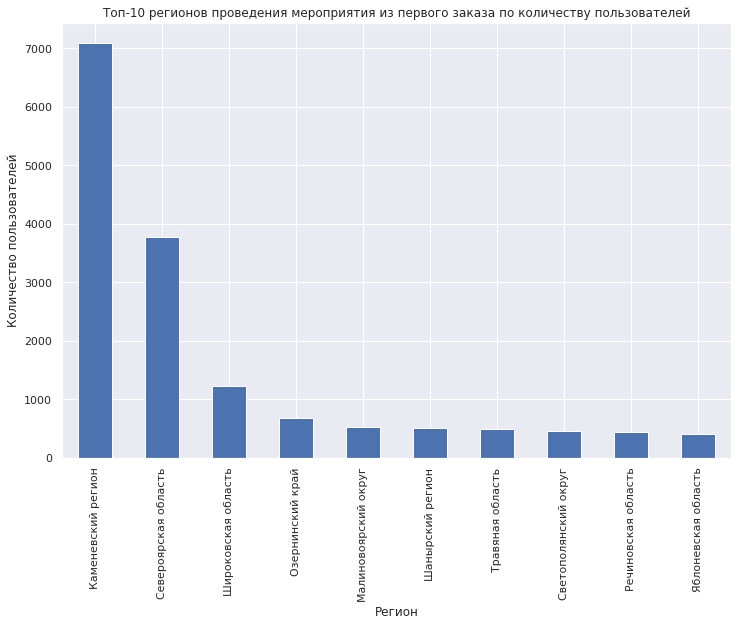

In [51]:
df_fr_abs.head(10).plot(figsize=(12, 8),
            kind='bar',
            legend=False,
            rot=90,
            grid=True,
            title=title_fr,
            xlabel='Регион',
            ylabel='Количество пользователей'
)

plt.show()

Hаспределение пользователей по регионам первого заказа неравномерно. Наибольшая доля пользователей приходится на Каменевский регион (33 %). Топ-10 регионов (см. визуализацию) суммарно охватывают более 75 % пользователей. Остальные регионы представлены значительно слабее, что отражает концентрацию активности в нескольких ключевых областях.

In [52]:
df_fs_abs = df_99['first_service'].value_counts()
df_fs_rel = df_99['first_service'].value_counts(normalize=True).astype(float).round(4)

df_fs = pd.DataFrame({
    'absolute': df_fs_abs,
    'relative': df_fs_rel
})

title_fs = 'Топ-10 билетных операторов первого заказа по количеству пользователей'

print('Билетные операторы первого заказа по количеству пользователей', df_fs, sep='\n')

Билетные операторы первого заказа по количеству пользователей
                        absolute  relative
Билеты без проблем          5156    0.2385
Мой билет                   2964    0.1371
Лови билет!                 2826    0.1307
Билеты в руки               2551    0.1180
Облачко                     2176    0.1007
Весь в билетах              1290    0.0597
Лучшие билеты               1183    0.0547
Прачечная                    573    0.0265
Край билетов                 458    0.0212
Дом культуры                 349    0.0161
Яблоко                       318    0.0147
Тебе билет!                  309    0.0143
Городской дом культуры       221    0.0102
Мир касс                     207    0.0096
За билетом!                  205    0.0095
Show_ticket                  161    0.0074
Быстробилет                  160    0.0074
Выступления.ру               100    0.0046
Восьмёрка                     86    0.0040
Быстрый кассир                61    0.0028
Crazy ticket!                 45   

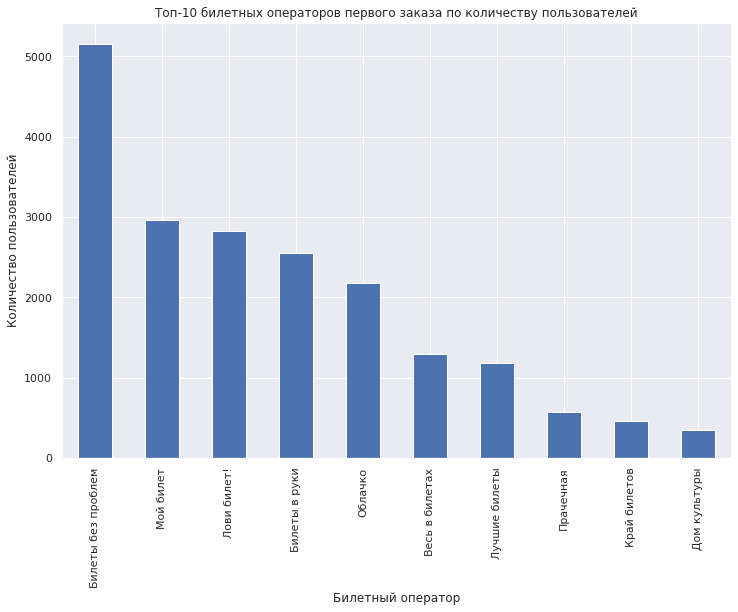

In [53]:
df_fs_abs.head(10).plot(figsize=(12, 8),
            kind='bar',
            legend=False,
            rot=90,
            grid=True,
            title=title_fs,
            xlabel='Билетный оператор',
            ylabel='Количество пользователей'
)

plt.show()

Распределение пользователей по билетным операторам первого заказа неравномерно. Топ-10 операторов (см. визуализацию) охватывают почти 90 % пользователей. При этом «Билеты без проблем» обеспечивают наибольшую долю пользователей - 24 %, а остальные операторы представлены значительно слабее.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [54]:
# Сделаем функцию, которая считает долю возвратов и 
# строит график для любого категориального признака с топ-N сегментов
def plot_return_rate(df, column, top_n=None, title=None):
    
    #Считаем количество пользователей и долю вернувшихся
    summary = df.groupby(column)['is_two'].agg(
                                            total_users = 'count',
                                            return_rate = 'mean'
    ).sort_values(by='return_rate', ascending=False)
    
    # Если top_n указано, выбираем топ-сегменты по числу пользователей
    if top_n is not None:
            top_segments = summary.sort_values(by='total_users', ascending=False).head(top_n).index
            summary = summary.loc[top_segments].sort_values(by='return_rate', ascending=False)
            
    print(title)
    display(summary)    
    
    summary['return_rate'].plot(kind='bar', 
                 figsize=(10, 6), 
                 title=title,
                 ylabel='Доля пользователей',
                 xlabel=column,
                 grid=True,
                 legend=False
    )
    
    plt.show()
    

Доля возвратов по типу мероприятия


,total_users,return_rate
first_event_type,,
выставки,406,0.635468
театр,4251,0.634909
концерты,9556,0.618146
стендап,1118,0.611807
другое,5397,0.595331
спорт,795,0.558491
ёлки,93,0.548387


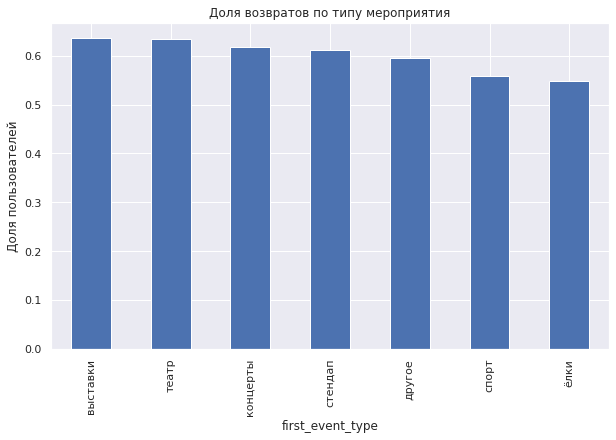

In [55]:
plot_return_rate(df_99, 'first_event_type', title='Доля возвратов по типу мероприятия')

Доля возвратов по типу устройства


,total_users,return_rate
first_device,,
desktop,3733,0.640771
mobile,17883,0.607504


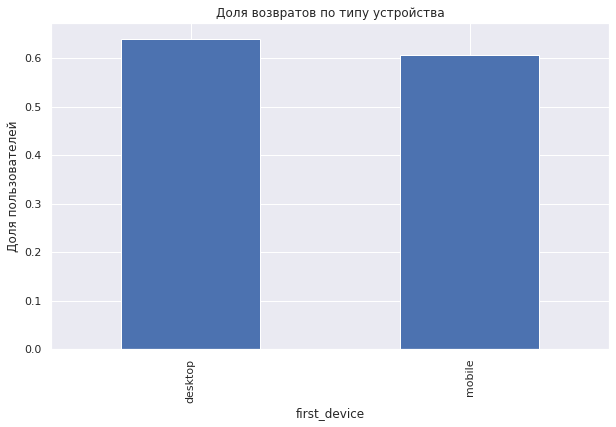

In [56]:
plot_return_rate(df_99, 'first_device', title='Доля возвратов по типу устройства')

Топ-10 регионов по доле возвратов


,total_users,return_rate
first_region,,
Шанырский регион,501,0.672655
Светополянский округ,458,0.657205
Широковская область,1229,0.646054
Североярская область,3771,0.638557
Речиновская область,439,0.633257
Каменевский регион,7086,0.623906
Травяная область,486,0.613169
Яблоневская область,409,0.591687
Малиновоярский округ,522,0.555556


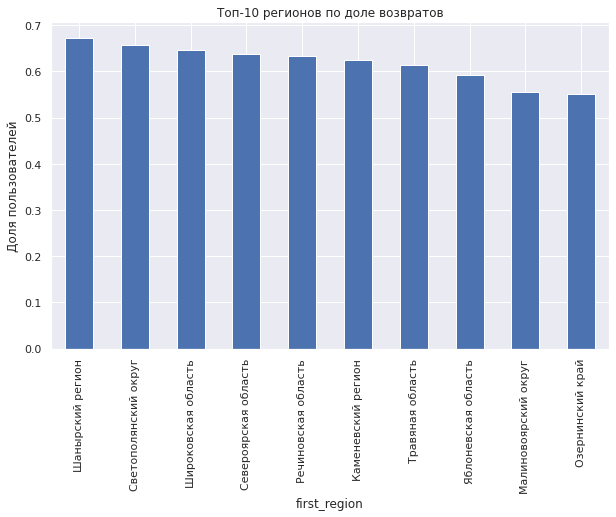

In [57]:
plot_return_rate(df_99, 'first_region', top_n=10, title='Топ-10 регионов по доле возвратов')

Топ-10 операторов по доле возвратов


,total_users,return_rate
first_service,,
Край билетов,458,0.655022
Дом культуры,349,0.638968
Весь в билетах,1290,0.630233
Билеты в руки,2551,0.626813
Прачечная,573,0.619546
Лучшие билеты,1183,0.613694
Облачко,2176,0.612132
Лови билет!,2826,0.611465
Мой билет,2964,0.608974


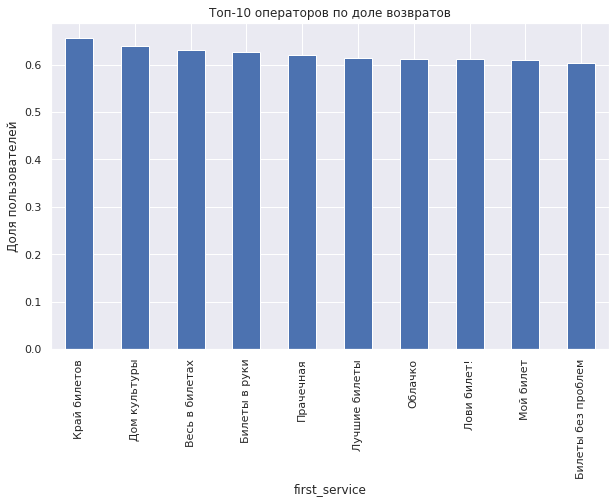

In [58]:
plot_return_rate(df_99, 'first_service', top_n=10, title='Топ-10 операторов по доле возвратов')


- **Сегменты с наибольшей вероятностью возврата**: пользователи, начавшие с выставок (63,5%) и театра (63,5%), десктоп-пользователи (64,1%), а также пользователи из Шанырского региона (67,3%) и Светополянского округа (65,7%). Среди операторов лидируют Край билетов (65,5%) и Дом культуры (63,9%).  

- **Успешные «точки входа»** наблюдаются как среди крупных сегментов (например, концерты и Каменевский регион с большим количеством пользователей и стабильной долей возвратов ≈62–64%), так и среди мелких сегментов (Шанырский регион, Край билетов), где доля возвратов выше среднего.  

- **Примечание:** в небольших сегментах (десятки–сотни пользователей) доли возвратов могут быть менее стабильными, поэтому интерпретацию следует сочетать с размером сегмента.


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1:** «Тип мероприятия влияет на вероятность возврата: спортивные мероприятия лучше концертов»  
- Данные показывают: доля возвратов для **спорта** — 55,8%, для **концертов** — 61,8%.  
- **Вывод:** гипотеза не подтверждается — пользователи, начавшие с концертов, возвращаются чаще, чем со спорта.

**Гипотеза 2:** «В регионах с большим числом пользователей выше доля повторных заказов»  
- Крупнейшие регионы по числу пользователей: Каменевский регион (7086 пользователей, 62,4%), Североярская область (3771 пользователь, 63,9%).  
- Мелкие регионы (десятки–сотни пользователей) иногда показывают более высокую долю возвратов (Шанырский регион 501 пользователь, 67,3%).  
- **Вывод:** гипотеза в чистом виде не подтверждается — высокая активность по числу пользователей не обязательно совпадает с высокой долей повторных заказов; малые регионы могут иметь более высокую долю возвратов.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


,1 заказ,2+ заказов
count,8360.0,13256.0
mean,634.9,624.8
std,912.3,678.0
min,0.0,0.0
25%,142.3,282.4
50%,391.3,509.0
75%,854.7,775.2
max,13212.9,13212.9


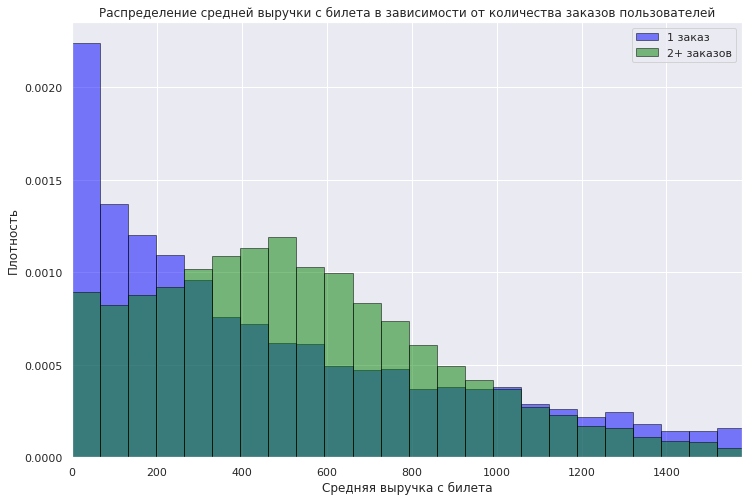

In [59]:
one_order_users = df_99[df_99['total_orders'] == 1]['avg_revenue']
return_users = df_99[df_99['total_orders'] >= 2]['avg_revenue']


display(
    pd.DataFrame({'1 заказ': one_order_users.describe().round(1),
                  '2+ заказов': return_users.describe().round(1)
                 })
)

upper = df_99['avg_revenue'].quantile(0.95)

plt.figure(figsize=(12, 8))
bins = 200

plt.hist(one_order_users, bins=bins, color='blue', alpha=0.5, edgecolor='black', density=True, label='1 заказ')
plt.hist(return_users, bins=bins, color='green', alpha=0.5, edgecolor='black', density=True, label='2+ заказов')

plt.xlim(0, upper)
plt.title('Распределение средней выручки с билета в зависимости от количества заказов пользователей')
plt.xlabel('Средняя выручка с билета')
plt.ylabel('Плотность')

plt.legend()
plt.grid(True)

plt.show()

~~**Диапазоны концентрации:**~~

- **1 заказ:** 25–75% пользователей тратят **142–855 руб.**, медиана — **391 руб.**  
- **2+ заказа:** 25–75% пользователей тратят **282–775 руб.**, медиана — **509 руб.**  

~~**Выводы:**~~

- Возвратные пользователи в среднем тратят больше, чем одноразовые.  
- Основная масса одноразовых заказов сосредоточена в нижнем ценовом диапазоне, возвратные — в среднем ценовом.
'''

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


,2-4 заказа,5+ заказов
count,7144.0,6112.0
mean,645.4,600.7
std,797.8,502.2
min,0.0,0.0
25%,231.0,344.2
50%,481.6,525.7
75%,826.0,733.0
max,13212.9,6566.8


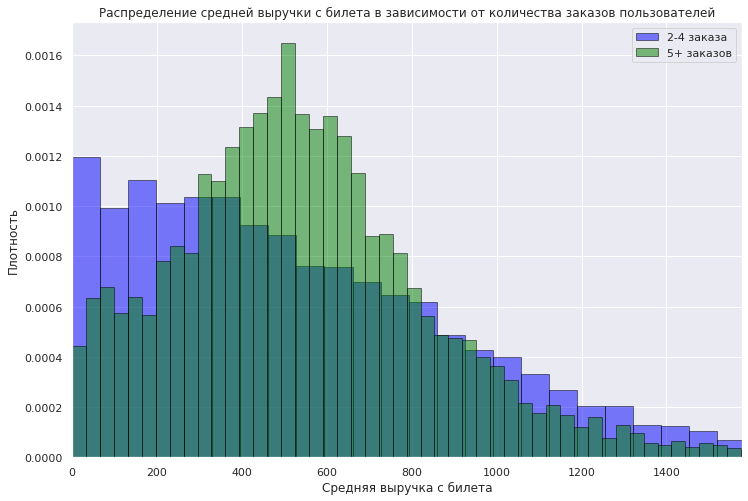

In [60]:
users_2_4 = df_99[(df_99['is_two'] == 1) & (df_99['is_five'] == 0)]['avg_revenue']
users_5plus = df_99[df_99['is_five'] == 1]['avg_revenue']

display(
    pd.DataFrame({'2-4 заказа': users_2_4.describe().round(1),
                  '5+ заказов': users_5plus.describe().round(1)
                 })
)

upper = df_99['avg_revenue'].quantile(0.95)

plt.figure(figsize=(12, 8))
bins = 200

plt.hist(users_2_4, bins=bins, color='blue', alpha=0.5, edgecolor='black', density=True, label='2-4 заказа')
plt.hist(users_5plus, bins=bins, color='green', alpha=0.5, edgecolor='black', density=True, label='5+ заказов')

plt.xlim(0, upper)
plt.title('Распределение средней выручки с билета в зависимости от количества заказов пользователей')
plt.xlabel('Средняя выручка с билета')
plt.ylabel('Плотность')

plt.legend()
plt.grid(True)

plt.show()

**Диапазоны концентрации:**

- **2–4 заказа:** 25–75% пользователей тратят **231–826 руб.**, медиана — **482 руб.**  
- **5+ заказов:** 25–75% пользователей тратят **344–733 руб.**, медиана — **526 руб.**  

**Выводы:**

- Пользователи с 5+ заказами в среднем тратят немного больше на билет, чем пользователи с 2–4 заказами.


---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

count    21616.000000
mean         2.744046
std          0.917788
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_tickets_count, dtype: float64

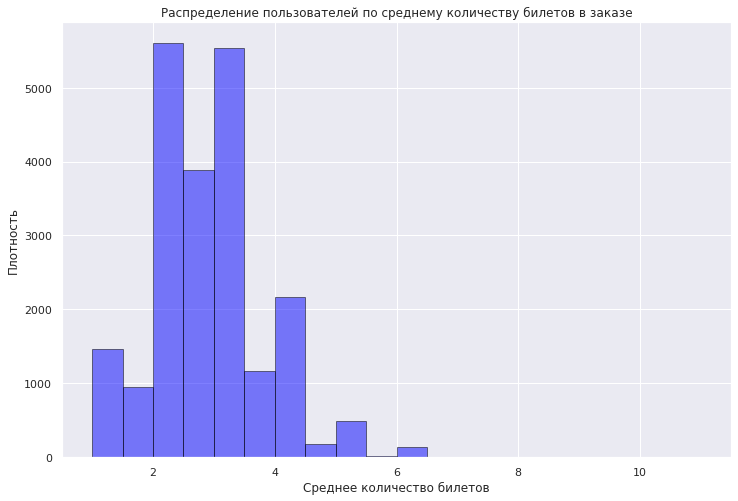

In [61]:
avg_tickets = df_99['avg_tickets_count']

display(avg_tickets.describe())

plt.figure(figsize=(12, 8))
bins = 20

plt.hist(avg_tickets, bins=bins, color='blue', alpha=0.5, edgecolor='black')

plt.title('Распределение пользователей по среднему количеству билетов в заказе')
plt.xlabel('Среднее количество билетов')
plt.ylabel('Плотность')

plt.grid(True)

plt.show()

Большинство пользователей покупают в среднем 2–3 билета.

In [62]:
df_99_ts = df_99.copy()

bins = [1, 2, 3, 5, df_99_ts['avg_tickets_count'].max()]
labels = ['1-2', '2-3', '3-5', '5+']
df_99_ts['ticket_segment'] = pd.cut(df_99_ts['avg_tickets_count'], 
                                    bins=bins, labels=labels, right=False)

segment_summary = df_99_ts.groupby('ticket_segment').agg(
    total_users=('first_event_type', 'count'),
    return_rate=('is_two', 'mean')
).round(3)

display(segment_summary)

,total_users,return_rate
ticket_segment,,
1-2,2412,0.513
2-3,9484,0.735
3-5,9059,0.543
5+,660,0.188


<div class="alert alert-info">

**Вывод** 
- Распределение пользователей по числу билетов явно неравномерное, с концентрацией в среднем диапазоне 2–5 билетов.

- Наибольшая доля повторных заказов наблюдается у пользователей с 2–3 билетами — 0,735. У пользователей с большим числом билетов (5+) доля возвратов аномально низкая, что, вероятно, связано с малым размером сегмента.

Таким образом, пользователи, покупающие 2–3 билета, возвращаются чаще, возможно, потому что это небольшие компании или семьи, которые посещают мероприятия вместе и проявляют большую лояльность. Пользователи с 5+ билетами, вероятно, совершают разовые групповые покупки (например, для организации, класса или события), поэтому повторные заказы у них встречаются реже.
</div>


---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [63]:
df_99.info()
display(df_99.head())

<class 'pandas.core.frame.DataFrame'>
Index: 21616 entries, 0002849b70a3ce2 to ffff00725179321
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_dt           21616 non-null  datetime64[ns]
 1   last_order_dt            21616 non-null  datetime64[ns]
 2   first_device             21616 non-null  object        
 3   first_region             21616 non-null  string        
 4   first_service            21616 non-null  string        
 5   first_event_type         21616 non-null  object        
 6   total_orders             21616 non-null  int64         
 7   avg_revenue              21616 non-null  float32       
 8   avg_tickets_count        21616 non-null  float64       
 9   avg_days_between_orders  13285 non-null  float32       
 10  is_two                   21616 non-null  int64         
 11  is_five                  21616 non-null  int64         
dtypes: datetime64

,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.000000,NaN,0,0
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010010,3.000000,75.0,1,0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213318,2.666667,51.0,1,0
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.000000,NaN,0,0
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


In [64]:
df_99_time = df_99.copy()

df_99_time['day_name'] = df_99_time['first_order_dt'].dt.day_name()

print(df_99_time['first_order_dt'].isna().sum())

0


In [65]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

days_summary = df_99_time.groupby('day_name').agg(
    total_users=('first_event_type', 'count'),
    return_rate=('is_two', 'mean')
).round(3)

days_summary = days_summary.loc[days_order]

display(days_summary)

,total_users,return_rate
day_name,,
Monday,2919,0.630
Tuesday,3165,0.619
Wednesday,3061,0.623
Thursday,3113,0.595
Friday,3257,0.597
Saturday,3324,0.628
Sunday,2777,0.601


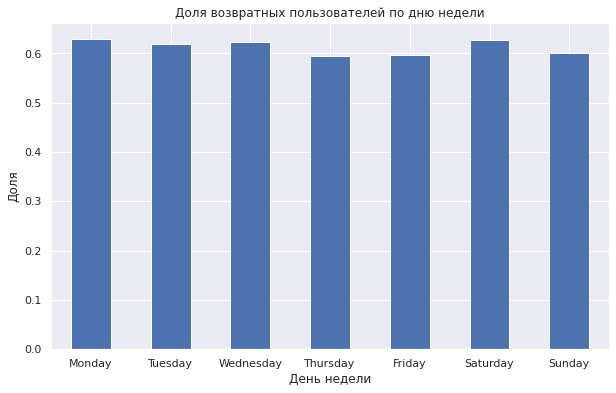

In [66]:
days_summary['return_rate'].plot(figsize=(10, 6),
            kind='bar',
            legend=False,
            rot=0,
            grid=True,
            title='Доля возвратных пользователей по дню недели',
            xlabel='День недели',
            ylabel='Доля'
)

plt.show()

Максимальная доля возвратов наблюдается в понедельник (0,630) и субботу (0,628), минимальная — в четверг (0,595) и пятницу (0,597). Разброс между днями недели невелик.  
**Вывод:** на вероятность возврата клиентов день недели первой покупки влияет несущественно.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


,2-4 заказа,5+ заказов
count,7144.0,6112.0
mean,21.3,9.9
std,28.5,7.8
min,0.0,0.0
25%,0.0,3.9
50%,9.0,8.1
75%,34.0,14.1
max,148.0,37.5


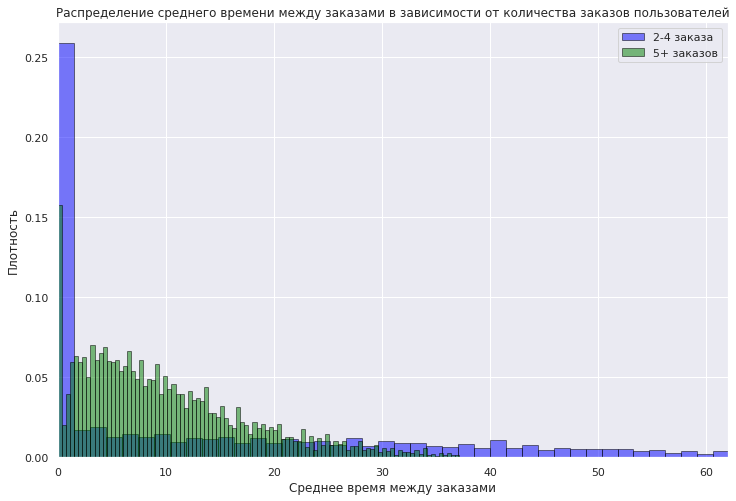

In [67]:
users_2_4_time = df_99_time[(df_99_time['is_two'] == 1) & (df_99['is_five'] == 0)]['avg_days_between_orders']
users_5plus_time = df_99_time[df_99_time['is_five'] == 1]['avg_days_between_orders']

display(
    pd.DataFrame({'2-4 заказа': users_2_4_time.describe().round(1),
                  '5+ заказов': users_5plus_time.describe().round(1)
                 })
)

upper = df_99_time['avg_days_between_orders'].quantile(0.95)

plt.figure(figsize=(12, 8))
bins = 100

plt.hist(users_2_4_time, bins=bins, color='blue', alpha=0.5, edgecolor='black', density=True, label='2-4 заказа')
plt.hist(users_5plus_time, bins=bins, color='green', alpha=0.5, edgecolor='black', density=True, label='5+ заказов')

plt.xlim(0, upper)
plt.title('Распределение среднего времени между заказами в зависимости от количества заказов пользователей')
plt.xlabel('Среднее время между заказами')
plt.ylabel('Плотность')

plt.legend()
plt.grid(True)

plt.show()

Пользователи с **2–4 заказами** совершают покупки реже и с большим разбросом: медиана 9 дней, 75-й перцентиль 34 дня. Пользователи с **5 и более заказами** покупают чаще и регулярно: медиана 8,1 дня, 75-й перцентиль 14,1 дня.     
**Вывод:** чем короче средний интервал между заказами, тем выше вероятность повторной покупки; высокая частота заказов коррелирует с лучшей удерживаемостью.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [68]:
correlation_matrix = df_99[['first_device', 'first_region', 'first_service', 
                           'first_event_type', 'total_orders', 'avg_revenue', 'avg_tickets_count', 
                           'avg_days_between_orders']].phik_matrix(
        interval_cols=['total_orders', 'avg_revenue', 'avg_tickets_count','avg_days_between_orders']
)

orders_correlations = correlation_matrix.loc[correlation_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)

title = 'Корреляционная матрица с коэффициентом phi_k для переменной total_orders:'

print(title, orders_correlations, sep='\n')

Корреляционная матрица с коэффициентом phi_k для переменной total_orders:
                         total_orders
avg_days_between_orders      0.284083
avg_tickets_count            0.225263
first_region                 0.114401
first_service                0.033895
first_event_type             0.026739
avg_revenue                  0.024043
first_device                 0.022462


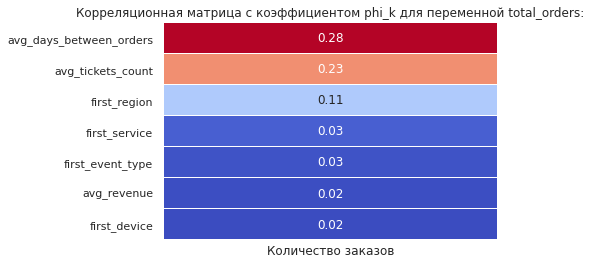

In [69]:
plt.figure(figsize=(6, 4))

sns.heatmap(orders_correlations,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            linewidth=0.5,
            cbar=False,
            xticklabels=False
)

plt.title(title)
plt.xlabel('Количество заказов')

plt.show()

**Вывод**

Наиболее связаны с количеством заказов следующие признаки:

* **avg_days_between_orders (0.284)** — пользователи с более частыми покупками чаще делают повторные заказы.  
* **avg_tickets_count (0.225)** — пользователи, покупающие больше билетов за заказ, склонны совершать больше заказов.  
* **first_region (0.114)** — регион первого заказа оказывает влияние на количество заказов.  

Остальные признаки практически не влияют на количество заказов.

**Таким образом**, поведение клиентов во времени и количество билетов важнее для объяснения повторных покупок, чем их демография или первый выбор сервиса.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

__Информация о данных__

- Использован датасет из 290 611 записей и 15 столбцов. После предобработки осталось 287 177 строки: удалено 3 434 записей (≈1,18 %), что не оказывает существенного влияния на результаты анализа. Единственный столбец с пропусками — `days_since_prev`, что логично для первых заказов пользователей.
- Даты `order_dt` и `order_ts` приведены к типу `datetime64[ns]` для дальнейшего анализа временных характеристик. Категориальные признаки (`device_type_canonical`, `currency_code`, `event_type_main`) приведены к типу `category` для снижения потребления памяти. Числовые столбцы оптимизированы по типам данных:  
  `revenue`, `revenue_rub`, `days_since_prev` → `float32`,  
  `tickets_count` → `int8`,  
  `order_id` → `int32`.
- Выполнен пересчёт выручки из `KZT` в `RUB` по дневному курсу с привязкой к дате заказа; результат сохранён в столбце `revenue_rub`. В этом же столбце выявлены некорректные значения: 381 отрицательное значение удалено, 5 522 нулевых значений сохранены, так как могут иметь смысл. После удаления отрицательных значений выполнена фильтрация выбросов по 99-му перцентилю.
- Категориальные данные не требовали нормализации: пропуски и некорректные значения отсутствуют.
- Анализ распределения `tickets_count` показал, что большинство заказов содержит `1–5 билетов`; редкие заказы с большим количеством билетов сохранены и не рассматривались как выбросы.
- Пропуски в `days_since_prev` интерпретируются как признак первого заказа пользователя.

**В результате данные очищены, приведены к единой валюте и оптимизированы, что обеспечивает корректность и устойчивость последующего анализа.**

__Основные результаты анализа__

- **Пользователи и заказы:** распределение неравномерное — основная часть пользователей совершает 1–4 заказа, сегмент 5+ заказов значительно меньше. Экстремальные значения по числу заказов удалены (<1 %).

- **Точки входа:** большинство первых заказов приходится на концерты (44 %); доминируют мобильные устройства (82,7 %); пользователи сконцентрированы в ограниченном числе регионов и операторов.

- **Факторы возврата:** выше доля возвратов у пользователей, начавших с отдельных типов мероприятий, регионов и операторов. Высокие значения встречаются как в крупных, так и в малых сегментах (важен размер сегмента).

- **Выручка и билеты:** возвратные пользователи в среднем тратят больше; максимальная доля повторных покупок — при 2–3 билетах; сегменты с 5+ билетами нестабильны из-за малого объёма.

- **Время:** день недели первой покупки влияет слабо; ключевой фактор удержания — короткий и регулярный интервал между заказами.

- **Корреляции с числом заказов:** наибольшая связь у avg_days_between_orders и avg_tickets_count; регион первого заказа влияет умеренно.

**Итог:** удержание в основном определяется частотой и регулярностью покупок, а не характеристиками первого заказа.


__Рекомендации__

- **Приоритетные сегменты**. Пользователи с короткими интервалами между заказами — ключевой драйвер удержания. Сегмент `2–4 заказа` — основной резерв для увеличения повторных покупок.

- **Работа с лояльными клиентами**. Пользователей с `5+ заказами` удерживать через программы лояльности и персональные предложения, без агрессивных скидок.

- **Маркетинг и таргетинг**. Использовать характеристики первого заказа (тип мероприятия, регион) для первичной сегментации и настройки рекламы. Точечно работать с малыми сегментами с высокой долей возвратов, контролируя масштаб из-за нестабильности метрик.

- **Триггерные механики**. Запускать коммуникации при превышении привычного интервала между заказами, особенно для пользователей с `2–4 заказами`.

- **Оптимизация бюджета**. Не учитывать день недели первой покупки как значимый фактор удержания. Стимулировать заказы с `2–3 билетами` как наиболее устойчивый сегмент. Не фокусироваться на пользователях с редкими крупными заказами (`5+ билетов`).

- **Общий подход**. Делать упор на `поведенческие признаки (частота покупок, интервалы)`, а не на демографию или контекст первого заказа. Сокращать расходы на одноразовых клиентов без признаков возврата.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**
https://github.com/panaggio99/20260127_ticketing_area